In [768]:
# Importar o componente que retornará informarções de uma ação da bolsa de valores
from yahooquery import Ticker
# Componentes de analise
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
import requests
from pandas import json_normalize
import pandas as pd
import math



In [769]:
# Vamos fazer uma analise PETR4 (Petrobrás)
petr = Ticker("PETR4.SA")
petr_dados = petr.history(period="max")
petr_dados.index = petr_dados.index.unique(level='date')
petr_dados.index = pd.to_datetime(petr_dados.index)




In [770]:
petr_dados.head()

,volume,high,open,close,low,adjclose,dividends,splits
date,,,,,,,,
2000-01-03,3.538944e+10,5.875,5.875,5.875,5.875,2.139587,0.0,0.0
2000-01-04,2.886144e+10,5.550,5.550,5.550,5.550,2.021227,0.0,0.0
2000-01-05,4.303360e+10,5.494,5.494,5.494,5.494,2.000833,0.0,0.0
2000-01-06,3.405568e+10,5.475,5.475,5.475,5.475,1.993913,0.0,0.0
2000-01-07,2.091264e+10,5.500,5.500,5.500,5.500,2.003018,0.0,0.0


<AxesSubplot: xlabel='date'>

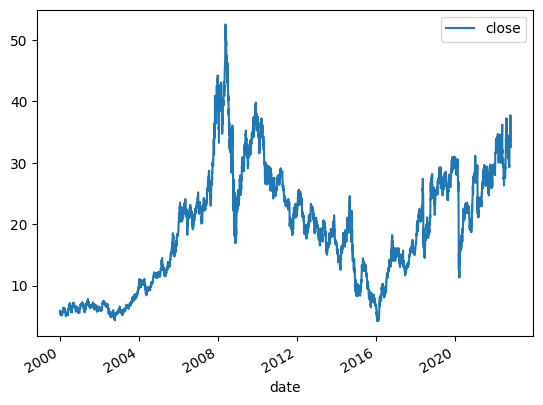

In [771]:
# Verificar a ação desde 2000
petr_dados[["close"]].plot()

<AxesSubplot: xlabel='date'>

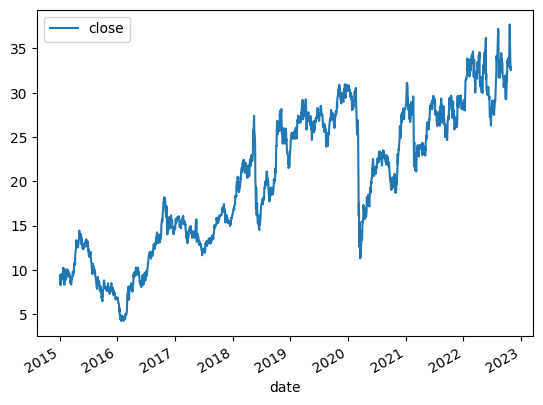

In [772]:
# Verificar a ação a partir 2015
petr_dados[petr_dados.index >= pd.to_datetime('2015-01-01')][["close"]].plot()

<AxesSubplot: xlabel='date'>

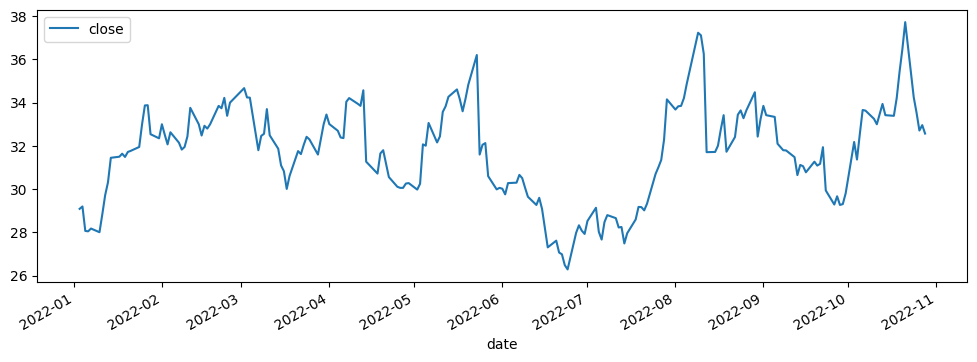

In [773]:
# Verificar a ação esse ano
fig, axs = plt.subplots(figsize=(12, 4))

petr_dados[petr_dados.index >= pd.to_datetime('2022-01-01')][["close"]].plot(ax=axs)

'----'

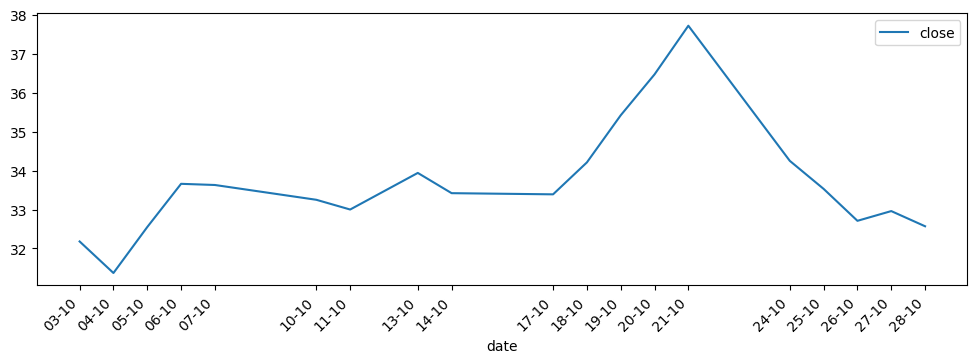

In [774]:
# Verificar o comportamento da ação no ultimo mês

fig, axs = plt.subplots(figsize=(12, 4))
dados_plot = petr_dados[petr_dados.index >= pd.to_datetime((datetime.now() - relativedelta(months=1)))][["close"]]
plot = dados_plot.plot(ax=axs)
x_labels = pd.to_datetime(dados_plot.index).strftime('%d-%m')


plot.set_xticks(dados_plot.index)
plot.set_xticklabels(x_labels, rotation=45)

"----"


In [775]:
# Analisar a base da SELIC

r = requests.get('https://api.bcb.gov.br/dados/serie/bcdata.sgs.11/dados?formato=json')
retorno_api = r.json()

dt_selic = json_normalize(retorno_api) 
dt_selic



,data,valor
0,04/06/1986,0.065041
1,05/06/1986,0.067397
2,06/06/1986,0.066740
3,09/06/1986,0.068247
4,10/06/1986,0.067041
...,...,...
9121,24/10/2022,0.050788
9122,25/10/2022,0.050788
9123,26/10/2022,0.050788
9124,27/10/2022,0.050788


In [776]:
# Transformar o retorno da API em uma série, pra se adaptar ao dataset da ação e para que possamos fazer algumas analises 

def converterDataObj(x):
    return datetime.strptime(x, "%d/%m/%Y")
dt_selic["valor"].index = dt_selic["data"].apply(converterDataObj)
dt_selic["valor"].index.names = ['date']

selic = pd.Series(dt_selic["valor"])
#Converter valores pra float

selic = pd.to_numeric(selic)
selic

date
1986-06-04    0.065041
1986-06-05    0.067397
1986-06-06    0.066740
1986-06-09    0.068247
1986-06-10    0.067041
                ...   
2022-10-24    0.050788
2022-10-25    0.050788
2022-10-26    0.050788
2022-10-27    0.050788
2022-10-28    0.050788
Name: valor, Length: 9126, dtype: float64

In [777]:
# Filtrar para apenas nos anos 2000 pra cima, pois é onde se inicia nosso dataset

selic = selic[selic.index >= pd.to_datetime('2000-01-01')]

<AxesSubplot: xlabel='date'>

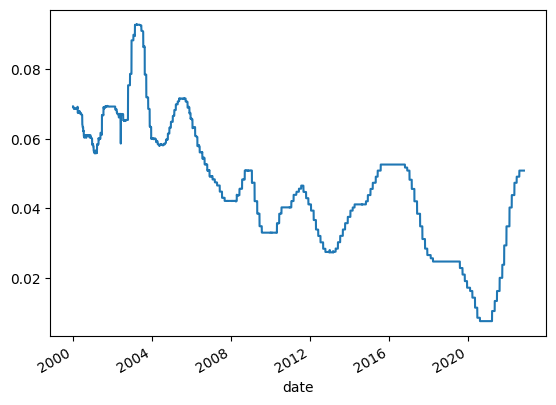

In [778]:
# Verificar o comportamento da SELIC durante os anos 

selic.plot()

In [779]:
# Unir selic com a base PETR4 

petr_dados = petr_dados.assign(selic = selic)

# Verificar se algum ficou em branco 

petr_dados.isna().sum()


volume        0
high          0
open          0
close         0
low           0
adjclose      0
dividends     0
splits        0
selic        62
dtype: int64

In [780]:
# verifiquei que será melhor fazer a predição dos ultimos dois anos, pois é onde houve uma oscilação menor 

petr_dados = petr_dados[petr_dados.index >= pd.to_datetime('2020-01-01')]


In [781]:
# Os em branco vou preencher com o ultimo valor

def preencherUltimoSelic (x):
     
    global selic     
    days = 1   
   
    while math.isnan(x['selic']):
        atual = pd.to_datetime(x.name - relativedelta(days=days)).strftime('%Y-%m-%d')
        if atual in selic.index :
            x['selic'] = selic.loc[atual]                  
        days += 1
    return x

selic_preenchidos = petr_dados[petr_dados["selic"].isna()].apply(preencherUltimoSelic, axis=1)

# depois que descobri os valores anteriores, vou preenchelos na base final

for index,value in selic_preenchidos.iterrows() :    
    petr_dados["selic"][index] = value['selic']

# por fim verificar se não há mais valores nulos

petr_dados.isna().sum()

volume       0
high         0
open         0
close        0
low          0
adjclose     0
dividends    0
splits       0
selic        0
dtype: int64

In [782]:
# Verificar correlação entre as colunas 

corr = petr_dados.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)


C:\Users\gabri\AppData\Local\Temp\ipykernel_26804\682635969.py:4: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)
c:\Python310\lib\site-packages\pandas\io\formats\style.py:3925: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
c:\Python310\lib\site-packages\pandas\io\formats\style.py:3926: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,volume,high,open,close,low,adjclose,dividends,splits,selic
volume,1.00,-0.14,-0.17,-0.17,-0.20,-0.03,0.16,nan,0.03
high,-0.14,1.00,1.00,1.00,1.00,0.85,0.06,nan,0.71
open,-0.17,1.00,1.00,0.99,1.00,0.84,0.04,nan,0.70
close,-0.17,1.00,0.99,1.00,1.00,0.84,0.06,nan,0.70
low,-0.20,1.00,1.00,1.00,1.00,0.83,0.04,nan,0.69
adjclose,-0.03,0.85,0.84,0.84,0.83,1.00,0.10,nan,0.90
dividends,0.16,0.06,0.04,0.06,0.04,0.10,1.00,nan,0.09
splits,nan,nan,nan,nan,nan,nan,nan,nan,nan
selic,0.03,0.71,0.70,0.70,0.69,0.90,0.09,nan,1.00


In [783]:
# Como a ideia é tentar prever diáriamente o valor fechamento, vou criar 5 colunas 
# com a porcentagem de aumento ou diminuição da ação nos ultimos 5 dias do dia em questão,
# acredito que com isso consigo adicionar, alem do valor do selic consigo adicionar a influencia da queda ou valorizacao
# baseado se no passado ela foi valorizada ou não


numeroDiasAnteriores = 15
menorData = petr_dados.iloc[numeroDiasAnteriores].name
def preencherPorcentagemAumento (x):     
    global petr_dados,numeroDiasAnteriores,menorData 
    if x.name <= menorData:
        count = 1
        while count <= numeroDiasAnteriores:
            x['val'+str(count)] = 1
            count +=1
        return x
    
    days = 1       
    
    count = 1
    closeValue = [x['close']]
    while count <= numeroDiasAnteriores:
        x['val'+str(count)] = False
        while x['val'+str(count)] == False:    
            atual = pd.to_datetime(x.name - relativedelta(days=days)).strftime('%Y-%m-%d')
            if atual in petr_dados.index :
                closeValue.append(petr_dados.loc[atual]['close'])           
                x['val'+str(count)] =  x['close'] / closeValue[-1]          
            days += 1
        count +=1
    return x
 
petr_dados = petr_dados.apply(preencherPorcentagemAumento, axis=1)


In [784]:
# Vamos limpar as colunas que não usaremos 

petr_dados.drop(["open","high","low","volume","adjclose","splits","dividends"],axis=1,inplace=True)

petr_dados


,close,selic,val1,val2,val3,val4,val5,val6,val7,val8,val9,val10,val11,val12,val13,val14,val15
date,,,,,,,,,,,,,,,,,
2020-01-02,30.700001,0.017089,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2020-01-03,30.450001,0.017089,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2020-01-06,30.809999,0.017089,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2020-01-07,30.690001,0.017089,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2020-01-08,30.500000,0.017089,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-24,34.250000,0.050788,0.908006,0.939128,0.966968,1.001169,1.025756,1.024835,1.009134,1.037879,1.030075,1.018436,1.017528,1.052227,1.091807,1.064326,1.149329
2022-10-25,33.529999,0.050788,0.978978,0.888918,0.919386,0.946640,0.980123,1.004193,1.003291,0.987920,1.016061,1.008421,0.997026,0.996138,1.030108,1.068856,1.041951
2022-10-26,32.709999,0.050788,0.975544,0.955036,0.867179,0.896902,0.923490,0.956153,0.979635,0.978755,0.963760,0.991212,0.983759,0.972643,0.971777,1.004916,1.042716


In [785]:
# Escalar os dados

from sklearn.preprocessing import MinMaxScaler
petr_dados_formatado = pd.DataFrame()

#salvar o valor maximo pra ser usado posteriormente 
max_close = max(petr_dados["close"])

petr_dados_formatado["close"] = petr_dados["close"] / max(petr_dados["close"])
petr_dados_formatado["selic"] = petr_dados["selic"] / max(petr_dados["selic"])

count = 1
while count <= numeroDiasAnteriores:
    petr_dados_formatado['val'+str(count)] = petr_dados['val'+str(count)] / max(petr_dados['val'+str(count)])   
    count +=1

petr_dados_formatado
#scaler = MinMaxScaler(feature_range=(0,1))
#petr_dados_formatado = scaler.fit_transform(petr_dados)
#petr_dados_formatado

,close,selic,val1,val2,val3,val4,val5,val6,val7,val8,val9,val10,val11,val12,val13,val14,val15
date,,,,,,,,,,,,,,,,,
2020-01-02,0.813892,0.336477,0.818182,0.803073,0.799166,0.833912,0.788408,0.784573,0.772517,0.741457,0.749674,0.729233,0.701220,0.663972,0.683710,0.679268,0.651848
2020-01-03,0.807264,0.336477,0.818182,0.803073,0.799166,0.833912,0.788408,0.784573,0.772517,0.741457,0.749674,0.729233,0.701220,0.663972,0.683710,0.679268,0.651848
2020-01-06,0.816808,0.336477,0.818182,0.803073,0.799166,0.833912,0.788408,0.784573,0.772517,0.741457,0.749674,0.729233,0.701220,0.663972,0.683710,0.679268,0.651848
2020-01-07,0.813627,0.336477,0.818182,0.803073,0.799166,0.833912,0.788408,0.784573,0.772517,0.741457,0.749674,0.729233,0.701220,0.663972,0.683710,0.679268,0.651848
2020-01-08,0.808590,0.336477,0.818182,0.803073,0.799166,0.833912,0.788408,0.784573,0.772517,0.741457,0.749674,0.729233,0.701220,0.663972,0.683710,0.679268,0.651848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-24,0.908006,1.000000,0.742914,0.754188,0.772768,0.834887,0.808714,0.804058,0.779573,0.769543,0.772221,0.742677,0.713511,0.698650,0.746480,0.722962,0.749187
2022-10-25,0.888918,1.000000,0.800982,0.713866,0.734742,0.789415,0.772736,0.787862,0.775060,0.732500,0.761714,0.735374,0.699134,0.661408,0.704295,0.726039,0.679194
2022-10-26,0.867179,1.000000,0.798173,0.766964,0.693020,0.747937,0.728086,0.750172,0.756785,0.725705,0.722506,0.722824,0.689831,0.645808,0.664413,0.682607,0.679692


In [786]:
# Separar treino e teste
from sklearn.model_selection import train_test_split

X = petr_dados_formatado.drop(["close"],axis=1)
y = petr_dados_formatado[["close"]]

training_data_len = int(np.ceil( len(petr_dados_formatado) * .95 ))

X_train = X[:training_data_len]
X_test = X[training_data_len:]
y_train = y[:training_data_len]
y_test = y[training_data_len:]

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [787]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (X_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=150, epochs=300)

Epoch 1/300
5/5 [==============================] - 2s 28ms/step - loss: 0.2747
Epoch 2/300
5/5 [==============================] - 0s 29ms/step - loss: 0.0592
Epoch 3/300
5/5 [==============================] - 0s 27ms/step - loss: 0.0293
Epoch 4/300
5/5 [==============================] - 0s 27ms/step - loss: 0.0319
Epoch 5/300
5/5 [==============================] - 0s 27ms/step - loss: 0.0193
Epoch 6/300
5/5 [==============================] - 0s 27ms/step - loss: 0.0202
Epoch 7/300
5/5 [==============================] - 0s 28ms/step - loss: 0.0178
Epoch 8/300
5/5 [==============================] - 0s 27ms/step - loss: 0.0172
Epoch 9/300
5/5 [==============================] - 0s 27ms/step - loss: 0.0166
Epoch 10/300
5/5 [==============================] - 0s 27ms/step - loss: 0.0163
Epoch 11/300
5/5 [==============================] - 0s 27ms/step - loss: 0.0161
Epoch 12/300
5/5 [==============================] - 0s 27ms/step - loss: 0.0157
Epoch 13/300
5/5 [==============================]

In [788]:
# Verificar o erro do modelo

predictions = model.predict(X_test)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

2/2 [==============================] - 0s 2ms/step


c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


close    0.038782
dtype: float64

1/1 [==============================] - 0s 351ms/step


C:\Users\gabri\AppData\Local\Temp\ipykernel_26804\2228031802.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predictions'] = predictions * max_close


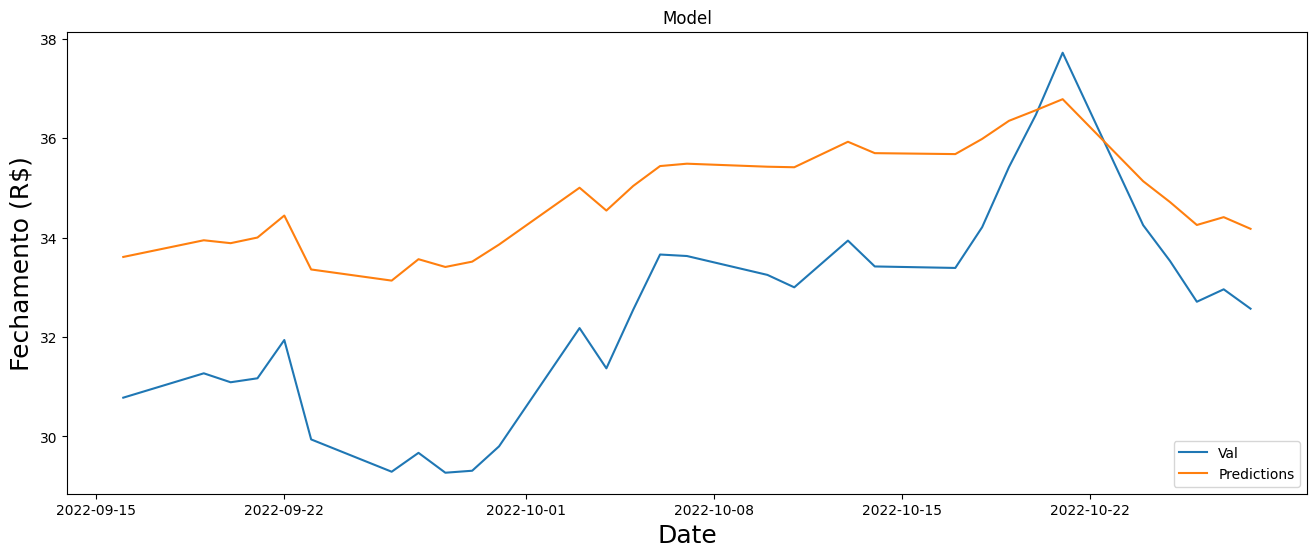

In [789]:
# plotar o resultado dos testes nos ultimos 30 dias
total = petr_dados_formatado.shape[0]
diasAnteriores = 30
predictions = model.predict(petr_dados_formatado[total-diasAnteriores:])
#train = petr_dados[:200]
valid = petr_dados[total-diasAnteriores:]
valid['predictions'] = predictions * max_close
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Fechamento (R$)', fontsize=18)
#plt.plot(train['Close'])
plt.plot(valid[['close', 'predictions']])
plt.legend([ 'Val', 'Predictions'], loc='lower right')
plt.show()


4/4 [==============================] - 0s 3ms/step


C:\Users\gabri\AppData\Local\Temp\ipykernel_26804\2984961114.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predictions'] = predictions * max_close


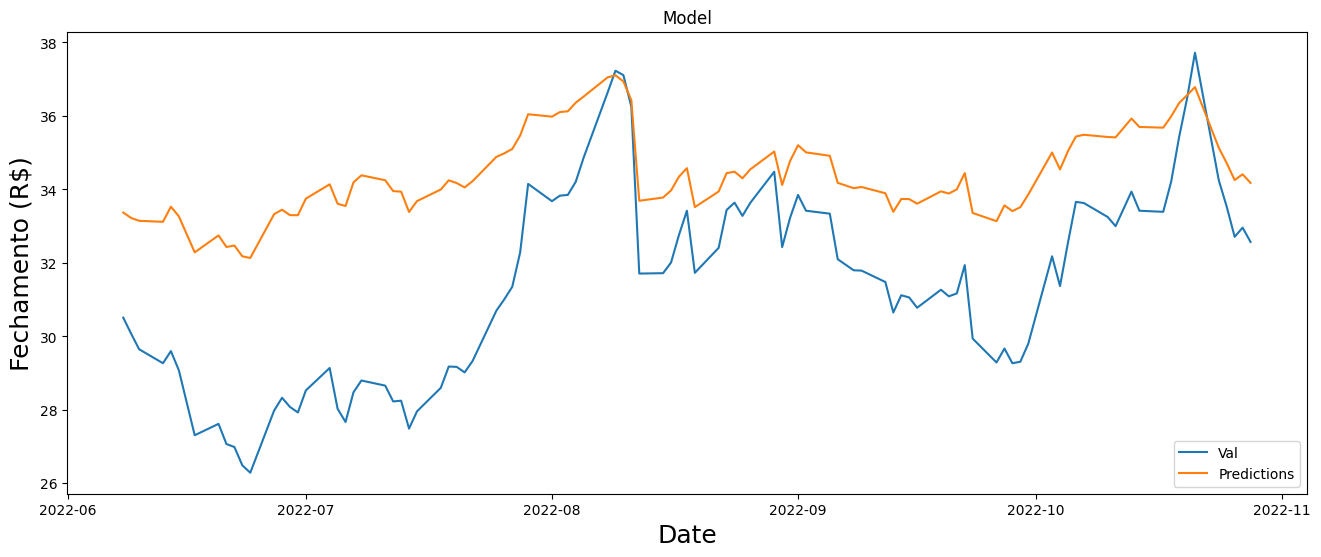

In [790]:
# plotar o resultado dos testes nos ultimos 100 dias
total = petr_dados_formatado.shape[0]
diasAnteriores = 100
predictions = model.predict(petr_dados_formatado[total-diasAnteriores:])
#train = petr_dados[:200]
valid = petr_dados[total-diasAnteriores:]
valid['predictions'] = predictions * max_close
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Fechamento (R$)', fontsize=18)
#plt.plot(train['Close'])
plt.plot(valid[['close', 'predictions']])
plt.legend([ 'Val', 'Predictions'], loc='lower right')
plt.show()

22/22 [==============================] - 0s 4ms/step


C:\Users\gabri\AppData\Local\Temp\ipykernel_26804\1254132064.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predictions'] = predictions * max_close


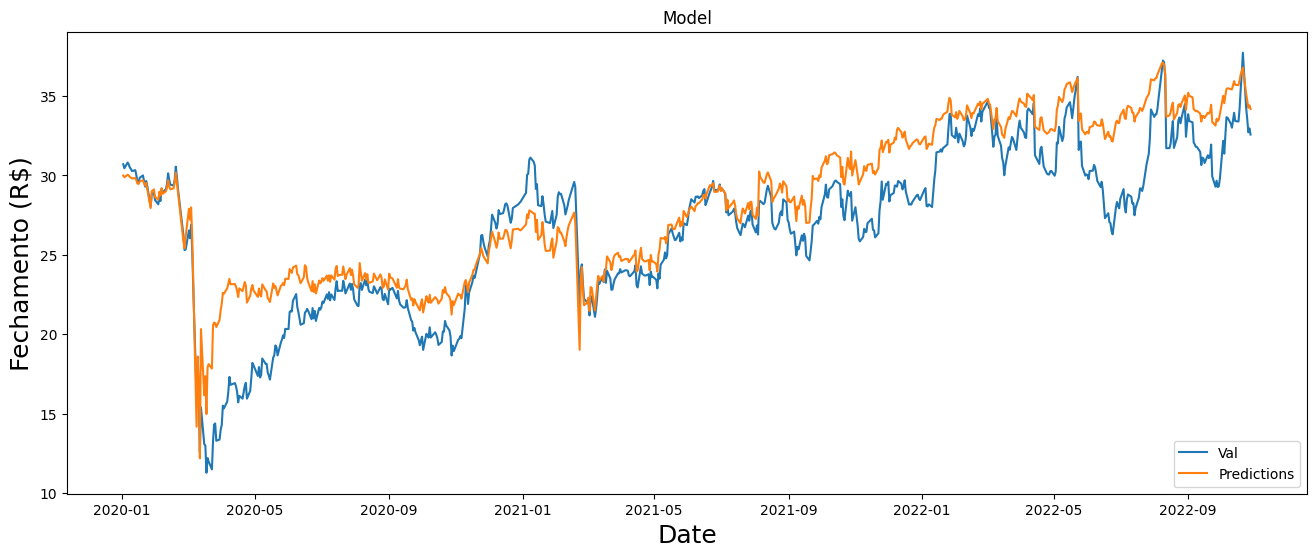

In [791]:
# plotar o resultado dos testes 
total = petr_dados_formatado.shape[0]
diasAnteriores = total
predictions = model.predict(petr_dados_formatado[total-diasAnteriores:])
#train = petr_dados[:200]
valid = petr_dados[total-diasAnteriores:]
valid['predictions'] = predictions * max_close
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Fechamento (R$)', fontsize=18)
#plt.plot(train['Close'])
plt.plot(valid[['close', 'predictions']])
plt.legend([ 'Val', 'Predictions'], loc='lower right')
plt.show()